# ViT — Binary Classification on GZ10 (Enhanced)

This notebook converts the 10-way GZ10 task into **binary classification** by grouping some class IDs as **positive**.
It includes:
- Demo vs Full training toggle
- Progress bars (tqdm)
- Confusion matrix + training curves
- Best checkpoint save & reload
- Mixed precision (AMP) when CUDA is available
- Robust validation split (stratified on binary label)
- Batch-aware transforms for Hugging Face Datasets


## 0) Install dependencies

In [21]:
# %pip install -U datasets timm torch torchvision transformers accelerate scikit-learn tqdm matplotlib numpy --quiet

## 1) Imports & configuration

In [22]:
import os, math, json, time, numpy as np
import torch
from torch import nn
from torch.utils.data import DataLoader
from torchvision import transforms
import timm
from datasets import load_dataset, DatasetDict
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_auc_score
import matplotlib.pyplot as plt
from tqdm.auto import tqdm
from pathlib import Path

SEED = 42
torch.manual_seed(SEED); np.random.seed(SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(SEED)

# ===== Toggle: Demo vs Full training =====
DEMO = False   # <<<< set to False for full training
EPOCHS = 3 if DEMO else 100
BATCH_TRAIN = 32 if DEMO else 64
BATCH_VAL = 64 if DEMO else 128

# AMP mixed precision
USE_AMP = torch.cuda.is_available()

DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
print('Device:', DEVICE, '| AMP:', USE_AMP, '| Epochs:', EPOCHS)


Device: cuda | AMP: True | Epochs: 100


## 2) Load GZ10

In [23]:
ds = load_dataset('MultimodalUniverse/gz10')
print(ds)
print(ds['train'].features)


DatasetDict({
    train: Dataset({
        features: ['gz10_label', 'redshift', 'object_id', 'rgb_image', 'rgb_pixel_scale'],
        num_rows: 17736
    })
})
{'gz10_label': Value(dtype='int32', id=None), 'redshift': Value(dtype='float32', id=None), 'object_id': Value(dtype='string', id=None), 'rgb_image': Image(mode=None, decode=True, id=None), 'rgb_pixel_scale': Value(dtype='float32', id=None)}


## 3) Define your binary mapping
Set the set `POSITIVES` to the class IDs you want to count as **positive (label=1)**.
The rest will be **negative (label=0)**.
Tip: print class counts after mapping to check balance.

In [24]:
# >>> Edit this to your target morphology <<<
POSITIVES = {0, 1, 2}  # placeholder; replace with the correct class IDs

def to_binary_label(y):
    return 1 if int(y) in POSITIVES else 0

def map_binary(example):
    example['label'] = to_binary_label(example['gz10_label'])
    return example

for sp in list(ds.keys()):
    ds[sp] = ds[sp].map(map_binary)

# Show class balance on train split
vals, counts = np.unique(ds['train']['label'], return_counts=True)
print('Train distribution (label -> count):', dict(zip(vals, counts)))


Train distribution (label -> count): {np.int64(0): np.int64(12157), np.int64(1): np.int64(5579)}


## 4) Create a validation split if missing (stratified on the **binary** label)

In [25]:
if 'validation' not in ds:
    labels = np.array(ds['train']['label'])
    sss = StratifiedShuffleSplit(n_splits=1, test_size=0.10, random_state=SEED)
    (train_idx, val_idx), = sss.split(np.zeros(len(labels)), labels)
    ds = DatasetDict({
        'train': ds['train'].select(train_idx.tolist()),
        'validation': ds['train'].select(val_idx.tolist()),
        **({'test': ds['test']} if 'test' in ds else {})
    })
print(ds)


DatasetDict({
    train: Dataset({
        features: ['gz10_label', 'redshift', 'object_id', 'rgb_image', 'rgb_pixel_scale', 'label'],
        num_rows: 15962
    })
    validation: Dataset({
        features: ['gz10_label', 'redshift', 'object_id', 'rgb_image', 'rgb_pixel_scale', 'label'],
        num_rows: 1774
    })
})


## 5) Transforms and dataset wrappers (batch-aware)

In [26]:
IMG_SIZE = 224
train_tf = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor()
])
val_tf = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor()
])

def make_transform(split):
    tfm = train_tf if split == 'train' else val_tf
    def _apply(batch):
        imgs = [tfm(img) for img in batch['rgb_image']]
        labels = [int(y) for y in batch['label']]
        return {'pixel_values': imgs, 'label': labels}
    return _apply

for sp in ['train', 'validation', 'test']:
    if sp in ds:
        ds[sp] = ds[sp].with_transform(make_transform(sp))


## 6) DataLoaders

In [27]:
train_loader = DataLoader(ds['train'], batch_size=BATCH_TRAIN, shuffle=True)
val_loader = DataLoader(ds['validation'], batch_size=BATCH_VAL, shuffle=False)
print('Batches | train:', len(train_loader), 'val:', len(val_loader))


Batches | train: 250 val: 14


## 7) Model, optimizer, scheduler, and AMP scaler

In [28]:
NUM_CLASSES = 2
model_name = 'vit_base_patch16_224'
model = timm.create_model(model_name, pretrained=True, num_classes=NUM_CLASSES)
model.to(DEVICE)

opt = torch.optim.AdamW(model.parameters(), lr=5e-4, weight_decay=0.05)
sched = torch.optim.lr_scheduler.CosineAnnealingLR(opt, T_max=EPOCHS)
loss_fn = nn.CrossEntropyLoss()
scaler = torch.cuda.amp.GradScaler(enabled=USE_AMP)

ckpt_dir = Path('checkpoints'); ckpt_dir.mkdir(exist_ok=True)
best_path = ckpt_dir / 'best_vit_gz10_binary.pth'
best_acc = -1.0


/tmp/ipykernel_3879844/1345948587.py:9: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler(enabled=USE_AMP)


## 8) Training & validation loops with progress bars

In [29]:
train_losses = []
val_accs = []
val_aucs = []

for epoch in range(EPOCHS):
    model.train()
    pbar = tqdm(train_loader, desc=f'Epoch {epoch+1}/{EPOCHS} [train]')
    running = 0.0
    for batch in pbar:
        xb = batch['pixel_values'].to(DEVICE)
        yb = batch['label'].to(DEVICE)

        opt.zero_grad()
        with torch.cuda.amp.autocast(enabled=USE_AMP):
            logits = model(xb)
            loss = loss_fn(logits, yb)

        scaler.scale(loss).backward()
        scaler.step(opt)
        scaler.update()

        running += loss.item()
        pbar.set_postfix({'loss': f'{running/((pbar.n or 1)):.4f}'})

    train_loss = running / max(1, len(train_loader))
    train_losses.append(train_loss)

    # Validation
    model.eval()
    y_true, y_pred, y_prob = [], [], []
    with torch.no_grad():
        for batch in tqdm(val_loader, desc=f'Epoch {epoch+1}/{EPOCHS} [val]'):
            xb = batch['pixel_values'].to(DEVICE)
            yb = batch['label']
            with torch.cuda.amp.autocast(enabled=USE_AMP):
                logits = model(xb)
            prob = torch.softmax(logits, dim=1)[:, 1].cpu().numpy()
            pr = logits.argmax(1).cpu().numpy()
            y_true += yb.numpy().tolist()
            y_pred += pr.tolist()
            y_prob += prob.tolist()

    acc = accuracy_score(y_true, y_pred)
    val_accs.append(acc)
    try:
        auc = roc_auc_score(y_true, y_prob)
    except Exception:
        auc = float('nan')
    val_aucs.append(auc)
    print(f'Epoch {epoch+1}: train_loss={train_loss:.4f} | val_acc={acc:.4f} | val_auc={auc:.4f}')

    if acc > best_acc:
        best_acc = acc
        torch.save({'model_state': model.state_dict(), 'acc': best_acc, 'epoch': epoch+1}, best_path)
        print(f'✅ Saved new best checkpoint: val_acc={best_acc:.4f} -> {best_path}')

    sched.step()


Epoch 1/100 [train]:   0%|          | 0/250 [00:00<?, ?it/s]/tmp/ipykernel_3879844/1907506674.py:14: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=USE_AMP):
Epoch 1/100 [val]:   0%|          | 0/14 [00:00<?, ?it/s]/tmp/ipykernel_3879844/1907506674.py:35: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=USE_AMP):
Epoch 1/100 [val]: 100%|██████████| 14/14 [00:08<00:00,  1.58it/s]


Epoch 1: train_loss=0.8668 | val_acc=0.6855 | val_auc=0.6209
✅ Saved new best checkpoint: val_acc=0.6855 -> checkpoints/best_vit_gz10_binary.pth


Epoch 2/100 [train]:   0%|          | 0/250 [00:00<?, ?it/s]/tmp/ipykernel_3879844/1907506674.py:14: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=USE_AMP):
Epoch 2/100 [val]:   0%|          | 0/14 [00:00<?, ?it/s]/tmp/ipykernel_3879844/1907506674.py:35: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=USE_AMP):
Epoch 2/100 [val]: 100%|██████████| 14/14 [00:07<00:00,  1.76it/s]


Epoch 2: train_loss=0.6170 | val_acc=0.6855 | val_auc=0.7148


Epoch 3/100 [train]:   0%|          | 0/250 [00:00<?, ?it/s]/tmp/ipykernel_3879844/1907506674.py:14: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=USE_AMP):
Epoch 3/100 [val]:   0%|          | 0/14 [00:00<?, ?it/s]/tmp/ipykernel_3879844/1907506674.py:35: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=USE_AMP):
Epoch 3/100 [val]: 100%|██████████| 14/14 [00:08<00:00,  1.58it/s]


Epoch 3: train_loss=0.5669 | val_acc=0.7435 | val_auc=0.7429
✅ Saved new best checkpoint: val_acc=0.7435 -> checkpoints/best_vit_gz10_binary.pth


Epoch 4/100 [train]:   0%|          | 0/250 [00:00<?, ?it/s]/tmp/ipykernel_3879844/1907506674.py:14: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=USE_AMP):
Epoch 4/100 [val]:   0%|          | 0/14 [00:00<?, ?it/s]/tmp/ipykernel_3879844/1907506674.py:35: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=USE_AMP):
Epoch 4/100 [val]: 100%|██████████| 14/14 [00:08<00:00,  1.61it/s]


Epoch 4: train_loss=0.5328 | val_acc=0.7621 | val_auc=0.7876
✅ Saved new best checkpoint: val_acc=0.7621 -> checkpoints/best_vit_gz10_binary.pth


Epoch 5/100 [train]:   0%|          | 0/250 [00:00<?, ?it/s]/tmp/ipykernel_3879844/1907506674.py:14: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=USE_AMP):
Epoch 5/100 [val]:   0%|          | 0/14 [00:00<?, ?it/s]/tmp/ipykernel_3879844/1907506674.py:35: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=USE_AMP):
Epoch 5/100 [val]: 100%|██████████| 14/14 [00:08<00:00,  1.71it/s]


Epoch 5: train_loss=0.5058 | val_acc=0.7649 | val_auc=0.8059
✅ Saved new best checkpoint: val_acc=0.7649 -> checkpoints/best_vit_gz10_binary.pth


Epoch 6/100 [train]:   0%|          | 0/250 [00:00<?, ?it/s]/tmp/ipykernel_3879844/1907506674.py:14: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=USE_AMP):
Epoch 6/100 [val]:   0%|          | 0/14 [00:00<?, ?it/s]/tmp/ipykernel_3879844/1907506674.py:35: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=USE_AMP):
Epoch 6/100 [val]: 100%|██████████| 14/14 [00:06<00:00,  2.02it/s]


Epoch 6: train_loss=0.4915 | val_acc=0.7345 | val_auc=0.8017


Epoch 7/100 [train]:   0%|          | 0/250 [00:00<?, ?it/s]/tmp/ipykernel_3879844/1907506674.py:14: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=USE_AMP):
Epoch 7/100 [val]:   0%|          | 0/14 [00:00<?, ?it/s]/tmp/ipykernel_3879844/1907506674.py:35: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=USE_AMP):
Epoch 7/100 [val]: 100%|██████████| 14/14 [00:07<00:00,  1.79it/s]


Epoch 7: train_loss=0.4703 | val_acc=0.7734 | val_auc=0.8082
✅ Saved new best checkpoint: val_acc=0.7734 -> checkpoints/best_vit_gz10_binary.pth


Epoch 8/100 [train]:   0%|          | 0/250 [00:00<?, ?it/s]/tmp/ipykernel_3879844/1907506674.py:14: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=USE_AMP):
Epoch 8/100 [val]:   0%|          | 0/14 [00:00<?, ?it/s]/tmp/ipykernel_3879844/1907506674.py:35: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=USE_AMP):
Epoch 8/100 [val]: 100%|██████████| 14/14 [00:07<00:00,  1.83it/s]


Epoch 8: train_loss=0.4681 | val_acc=0.7965 | val_auc=0.8318
✅ Saved new best checkpoint: val_acc=0.7965 -> checkpoints/best_vit_gz10_binary.pth


Epoch 9/100 [train]:   0%|          | 0/250 [00:00<?, ?it/s]/tmp/ipykernel_3879844/1907506674.py:14: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=USE_AMP):
Epoch 9/100 [val]:   0%|          | 0/14 [00:00<?, ?it/s]/tmp/ipykernel_3879844/1907506674.py:35: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=USE_AMP):
Epoch 9/100 [val]: 100%|██████████| 14/14 [00:10<00:00,  1.33it/s]


Epoch 9: train_loss=0.4518 | val_acc=0.7785 | val_auc=0.8275


Epoch 10/100 [train]:   0%|          | 0/250 [00:00<?, ?it/s]/tmp/ipykernel_3879844/1907506674.py:14: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=USE_AMP):
Epoch 10/100 [val]:   0%|          | 0/14 [00:00<?, ?it/s]/tmp/ipykernel_3879844/1907506674.py:35: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=USE_AMP):
Epoch 10/100 [val]: 100%|██████████| 14/14 [00:08<00:00,  1.71it/s]


Epoch 10: train_loss=0.4486 | val_acc=0.7706 | val_auc=0.8240


Epoch 11/100 [train]:   0%|          | 0/250 [00:00<?, ?it/s]/tmp/ipykernel_3879844/1907506674.py:14: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=USE_AMP):
Epoch 11/100 [val]:   0%|          | 0/14 [00:00<?, ?it/s]/tmp/ipykernel_3879844/1907506674.py:35: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=USE_AMP):
Epoch 11/100 [val]: 100%|██████████| 14/14 [00:08<00:00,  1.65it/s]


Epoch 11: train_loss=0.4234 | val_acc=0.8117 | val_auc=0.8614
✅ Saved new best checkpoint: val_acc=0.8117 -> checkpoints/best_vit_gz10_binary.pth


Epoch 12/100 [train]:   0%|          | 0/250 [00:00<?, ?it/s]/tmp/ipykernel_3879844/1907506674.py:14: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=USE_AMP):
Epoch 12/100 [val]:   0%|          | 0/14 [00:00<?, ?it/s]/tmp/ipykernel_3879844/1907506674.py:35: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=USE_AMP):
Epoch 12/100 [val]: 100%|██████████| 14/14 [00:09<00:00,  1.48it/s]


Epoch 12: train_loss=0.4224 | val_acc=0.8224 | val_auc=0.8715
✅ Saved new best checkpoint: val_acc=0.8224 -> checkpoints/best_vit_gz10_binary.pth


Epoch 13/100 [train]:   0%|          | 0/250 [00:00<?, ?it/s]/tmp/ipykernel_3879844/1907506674.py:14: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=USE_AMP):
Epoch 13/100 [val]:   0%|          | 0/14 [00:00<?, ?it/s]/tmp/ipykernel_3879844/1907506674.py:35: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=USE_AMP):
Epoch 13/100 [val]: 100%|██████████| 14/14 [00:07<00:00,  1.97it/s]


Epoch 13: train_loss=0.4041 | val_acc=0.8100 | val_auc=0.8555


Epoch 14/100 [train]:   0%|          | 0/250 [00:00<?, ?it/s]/tmp/ipykernel_3879844/1907506674.py:14: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=USE_AMP):
Epoch 14/100 [val]:   0%|          | 0/14 [00:00<?, ?it/s]/tmp/ipykernel_3879844/1907506674.py:35: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=USE_AMP):
Epoch 14/100 [val]: 100%|██████████| 14/14 [00:08<00:00,  1.62it/s]


Epoch 14: train_loss=0.3967 | val_acc=0.7988 | val_auc=0.8730


Epoch 15/100 [train]:   0%|          | 0/250 [00:00<?, ?it/s]/tmp/ipykernel_3879844/1907506674.py:14: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=USE_AMP):
Epoch 15/100 [val]:   0%|          | 0/14 [00:00<?, ?it/s]/tmp/ipykernel_3879844/1907506674.py:35: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=USE_AMP):
Epoch 15/100 [val]: 100%|██████████| 14/14 [00:08<00:00,  1.74it/s]


Epoch 15: train_loss=0.4167 | val_acc=0.8292 | val_auc=0.8741
✅ Saved new best checkpoint: val_acc=0.8292 -> checkpoints/best_vit_gz10_binary.pth


Epoch 16/100 [train]:   0%|          | 0/250 [00:00<?, ?it/s]/tmp/ipykernel_3879844/1907506674.py:14: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=USE_AMP):
Epoch 16/100 [val]:   0%|          | 0/14 [00:00<?, ?it/s]/tmp/ipykernel_3879844/1907506674.py:35: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=USE_AMP):
Epoch 16/100 [val]: 100%|██████████| 14/14 [00:08<00:00,  1.65it/s]


Epoch 16: train_loss=0.4013 | val_acc=0.8213 | val_auc=0.8630


Epoch 17/100 [train]:   0%|          | 0/250 [00:00<?, ?it/s]/tmp/ipykernel_3879844/1907506674.py:14: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=USE_AMP):
Epoch 17/100 [val]:   0%|          | 0/14 [00:00<?, ?it/s]/tmp/ipykernel_3879844/1907506674.py:35: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=USE_AMP):
Epoch 17/100 [val]: 100%|██████████| 14/14 [00:08<00:00,  1.59it/s]


Epoch 17: train_loss=0.3845 | val_acc=0.8230 | val_auc=0.8641


Epoch 18/100 [train]:   0%|          | 0/250 [00:00<?, ?it/s]/tmp/ipykernel_3879844/1907506674.py:14: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=USE_AMP):
Epoch 18/100 [val]:   0%|          | 0/14 [00:00<?, ?it/s]/tmp/ipykernel_3879844/1907506674.py:35: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=USE_AMP):
Epoch 18/100 [val]: 100%|██████████| 14/14 [00:08<00:00,  1.74it/s]


Epoch 18: train_loss=0.3697 | val_acc=0.8348 | val_auc=0.8656
✅ Saved new best checkpoint: val_acc=0.8348 -> checkpoints/best_vit_gz10_binary.pth


Epoch 19/100 [train]:   0%|          | 0/250 [00:00<?, ?it/s]/tmp/ipykernel_3879844/1907506674.py:14: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=USE_AMP):
Epoch 19/100 [val]:   0%|          | 0/14 [00:00<?, ?it/s]/tmp/ipykernel_3879844/1907506674.py:35: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=USE_AMP):
Epoch 19/100 [val]: 100%|██████████| 14/14 [00:08<00:00,  1.62it/s]


Epoch 19: train_loss=0.3679 | val_acc=0.8055 | val_auc=0.8616


Epoch 20/100 [train]:   0%|          | 0/250 [00:00<?, ?it/s]/tmp/ipykernel_3879844/1907506674.py:14: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=USE_AMP):
Epoch 20/100 [val]:   0%|          | 0/14 [00:00<?, ?it/s]/tmp/ipykernel_3879844/1907506674.py:35: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=USE_AMP):
Epoch 20/100 [val]: 100%|██████████| 14/14 [00:09<00:00,  1.46it/s]


Epoch 20: train_loss=0.3656 | val_acc=0.8410 | val_auc=0.8897
✅ Saved new best checkpoint: val_acc=0.8410 -> checkpoints/best_vit_gz10_binary.pth


Epoch 21/100 [train]:   0%|          | 0/250 [00:00<?, ?it/s]/tmp/ipykernel_3879844/1907506674.py:14: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=USE_AMP):
Epoch 21/100 [val]:   0%|          | 0/14 [00:00<?, ?it/s]/tmp/ipykernel_3879844/1907506674.py:35: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=USE_AMP):
Epoch 21/100 [val]: 100%|██████████| 14/14 [00:07<00:00,  1.88it/s]


Epoch 21: train_loss=0.3524 | val_acc=0.8484 | val_auc=0.8971
✅ Saved new best checkpoint: val_acc=0.8484 -> checkpoints/best_vit_gz10_binary.pth


Epoch 22/100 [train]:   0%|          | 0/250 [00:00<?, ?it/s]/tmp/ipykernel_3879844/1907506674.py:14: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=USE_AMP):
Epoch 22/100 [val]:   0%|          | 0/14 [00:00<?, ?it/s]/tmp/ipykernel_3879844/1907506674.py:35: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=USE_AMP):
Epoch 22/100 [val]: 100%|██████████| 14/14 [00:08<00:00,  1.69it/s]


Epoch 22: train_loss=0.3471 | val_acc=0.8585 | val_auc=0.9001
✅ Saved new best checkpoint: val_acc=0.8585 -> checkpoints/best_vit_gz10_binary.pth


Epoch 23/100 [train]:   0%|          | 0/250 [00:00<?, ?it/s]/tmp/ipykernel_3879844/1907506674.py:14: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=USE_AMP):
Epoch 23/100 [val]:   0%|          | 0/14 [00:00<?, ?it/s]/tmp/ipykernel_3879844/1907506674.py:35: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=USE_AMP):
Epoch 23/100 [val]: 100%|██████████| 14/14 [00:09<00:00,  1.42it/s]


Epoch 23: train_loss=0.3409 | val_acc=0.8467 | val_auc=0.8910


Epoch 24/100 [train]:   0%|          | 0/250 [00:00<?, ?it/s]/tmp/ipykernel_3879844/1907506674.py:14: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=USE_AMP):
Epoch 24/100 [val]:   0%|          | 0/14 [00:00<?, ?it/s]/tmp/ipykernel_3879844/1907506674.py:35: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=USE_AMP):
Epoch 24/100 [val]: 100%|██████████| 14/14 [00:09<00:00,  1.43it/s]


Epoch 24: train_loss=0.3320 | val_acc=0.8168 | val_auc=0.8946


Epoch 25/100 [train]:   0%|          | 0/250 [00:00<?, ?it/s]/tmp/ipykernel_3879844/1907506674.py:14: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=USE_AMP):
Epoch 25/100 [val]:   0%|          | 0/14 [00:00<?, ?it/s]/tmp/ipykernel_3879844/1907506674.py:35: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=USE_AMP):
Epoch 25/100 [val]: 100%|██████████| 14/14 [00:09<00:00,  1.53it/s]


Epoch 25: train_loss=0.3261 | val_acc=0.8405 | val_auc=0.9066


Epoch 26/100 [train]:   0%|          | 0/250 [00:00<?, ?it/s]/tmp/ipykernel_3879844/1907506674.py:14: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=USE_AMP):
Epoch 26/100 [val]:   0%|          | 0/14 [00:00<?, ?it/s]/tmp/ipykernel_3879844/1907506674.py:35: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=USE_AMP):
Epoch 26/100 [val]: 100%|██████████| 14/14 [00:07<00:00,  1.98it/s]


Epoch 26: train_loss=0.3164 | val_acc=0.8647 | val_auc=0.9087
✅ Saved new best checkpoint: val_acc=0.8647 -> checkpoints/best_vit_gz10_binary.pth


Epoch 27/100 [train]:   0%|          | 0/250 [00:00<?, ?it/s]/tmp/ipykernel_3879844/1907506674.py:14: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=USE_AMP):
Epoch 27/100 [val]:   0%|          | 0/14 [00:00<?, ?it/s]/tmp/ipykernel_3879844/1907506674.py:35: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=USE_AMP):
Epoch 27/100 [val]: 100%|██████████| 14/14 [00:07<00:00,  1.78it/s]


Epoch 27: train_loss=0.3159 | val_acc=0.8630 | val_auc=0.9140


Epoch 28/100 [train]:   0%|          | 0/250 [00:00<?, ?it/s]/tmp/ipykernel_3879844/1907506674.py:14: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=USE_AMP):
Epoch 28/100 [val]:   0%|          | 0/14 [00:00<?, ?it/s]/tmp/ipykernel_3879844/1907506674.py:35: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=USE_AMP):
Epoch 28/100 [val]: 100%|██████████| 14/14 [00:07<00:00,  1.84it/s]


Epoch 28: train_loss=0.3068 | val_acc=0.8709 | val_auc=0.9163
✅ Saved new best checkpoint: val_acc=0.8709 -> checkpoints/best_vit_gz10_binary.pth


Epoch 29/100 [train]:   0%|          | 0/250 [00:00<?, ?it/s]/tmp/ipykernel_3879844/1907506674.py:14: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=USE_AMP):
Epoch 29/100 [val]:   0%|          | 0/14 [00:00<?, ?it/s]/tmp/ipykernel_3879844/1907506674.py:35: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=USE_AMP):
Epoch 29/100 [val]: 100%|██████████| 14/14 [00:07<00:00,  1.98it/s]


Epoch 29: train_loss=0.3052 | val_acc=0.8675 | val_auc=0.9152


Epoch 30/100 [train]:   0%|          | 0/250 [00:00<?, ?it/s]/tmp/ipykernel_3879844/1907506674.py:14: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=USE_AMP):
Epoch 30/100 [val]:   0%|          | 0/14 [00:00<?, ?it/s]/tmp/ipykernel_3879844/1907506674.py:35: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=USE_AMP):
Epoch 30/100 [val]: 100%|██████████| 14/14 [00:08<00:00,  1.61it/s]


Epoch 30: train_loss=0.2982 | val_acc=0.8754 | val_auc=0.9209
✅ Saved new best checkpoint: val_acc=0.8754 -> checkpoints/best_vit_gz10_binary.pth


Epoch 31/100 [train]:   0%|          | 0/250 [00:00<?, ?it/s]/tmp/ipykernel_3879844/1907506674.py:14: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=USE_AMP):
Epoch 31/100 [val]:   0%|          | 0/14 [00:00<?, ?it/s]/tmp/ipykernel_3879844/1907506674.py:35: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=USE_AMP):
Epoch 31/100 [val]: 100%|██████████| 14/14 [00:09<00:00,  1.43it/s]


Epoch 31: train_loss=0.2949 | val_acc=0.8692 | val_auc=0.9176


Epoch 32/100 [train]:   0%|          | 0/250 [00:00<?, ?it/s]/tmp/ipykernel_3879844/1907506674.py:14: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=USE_AMP):
Epoch 32/100 [val]:   0%|          | 0/14 [00:00<?, ?it/s]/tmp/ipykernel_3879844/1907506674.py:35: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=USE_AMP):
Epoch 32/100 [val]: 100%|██████████| 14/14 [00:08<00:00,  1.57it/s]


Epoch 32: train_loss=0.2888 | val_acc=0.8568 | val_auc=0.9085


Epoch 33/100 [train]:   0%|          | 0/250 [00:00<?, ?it/s]/tmp/ipykernel_3879844/1907506674.py:14: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=USE_AMP):
Epoch 33/100 [val]:   0%|          | 0/14 [00:00<?, ?it/s]/tmp/ipykernel_3879844/1907506674.py:35: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=USE_AMP):
Epoch 33/100 [val]: 100%|██████████| 14/14 [00:07<00:00,  1.97it/s]


Epoch 33: train_loss=0.2856 | val_acc=0.8630 | val_auc=0.9170


Epoch 34/100 [train]:   0%|          | 0/250 [00:00<?, ?it/s]/tmp/ipykernel_3879844/1907506674.py:14: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=USE_AMP):
Epoch 34/100 [val]:   0%|          | 0/14 [00:00<?, ?it/s]/tmp/ipykernel_3879844/1907506674.py:35: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=USE_AMP):
Epoch 34/100 [val]: 100%|██████████| 14/14 [00:08<00:00,  1.56it/s]


Epoch 34: train_loss=0.2780 | val_acc=0.8760 | val_auc=0.9167
✅ Saved new best checkpoint: val_acc=0.8760 -> checkpoints/best_vit_gz10_binary.pth


Epoch 35/100 [train]:   0%|          | 0/250 [00:00<?, ?it/s]/tmp/ipykernel_3879844/1907506674.py:14: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=USE_AMP):
Epoch 35/100 [val]:   0%|          | 0/14 [00:00<?, ?it/s]/tmp/ipykernel_3879844/1907506674.py:35: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=USE_AMP):
Epoch 35/100 [val]: 100%|██████████| 14/14 [00:07<00:00,  1.94it/s]


Epoch 35: train_loss=0.2734 | val_acc=0.8715 | val_auc=0.9170


Epoch 36/100 [train]:   0%|          | 0/250 [00:00<?, ?it/s]/tmp/ipykernel_3879844/1907506674.py:14: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=USE_AMP):
Epoch 36/100 [val]:   0%|          | 0/14 [00:00<?, ?it/s]/tmp/ipykernel_3879844/1907506674.py:35: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=USE_AMP):
Epoch 36/100 [val]: 100%|██████████| 14/14 [00:08<00:00,  1.60it/s]


Epoch 36: train_loss=0.2659 | val_acc=0.8788 | val_auc=0.9286
✅ Saved new best checkpoint: val_acc=0.8788 -> checkpoints/best_vit_gz10_binary.pth


Epoch 37/100 [train]:   0%|          | 0/250 [00:00<?, ?it/s]/tmp/ipykernel_3879844/1907506674.py:14: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=USE_AMP):
Epoch 37/100 [val]:   0%|          | 0/14 [00:00<?, ?it/s]/tmp/ipykernel_3879844/1907506674.py:35: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=USE_AMP):
Epoch 37/100 [val]: 100%|██████████| 14/14 [00:07<00:00,  1.78it/s]


Epoch 37: train_loss=0.2589 | val_acc=0.8760 | val_auc=0.9205


Epoch 38/100 [train]:   0%|          | 0/250 [00:00<?, ?it/s]/tmp/ipykernel_3879844/1907506674.py:14: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=USE_AMP):
Epoch 38/100 [val]:   0%|          | 0/14 [00:00<?, ?it/s]/tmp/ipykernel_3879844/1907506674.py:35: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=USE_AMP):
Epoch 38/100 [val]: 100%|██████████| 14/14 [00:08<00:00,  1.72it/s]


Epoch 38: train_loss=0.2559 | val_acc=0.8771 | val_auc=0.9238


Epoch 39/100 [train]:   0%|          | 0/250 [00:00<?, ?it/s]/tmp/ipykernel_3879844/1907506674.py:14: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=USE_AMP):
Epoch 39/100 [val]:   0%|          | 0/14 [00:00<?, ?it/s]/tmp/ipykernel_3879844/1907506674.py:35: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=USE_AMP):
Epoch 39/100 [val]: 100%|██████████| 14/14 [00:10<00:00,  1.39it/s]


Epoch 39: train_loss=0.2548 | val_acc=0.8782 | val_auc=0.9226


Epoch 40/100 [train]:   0%|          | 0/250 [00:00<?, ?it/s]/tmp/ipykernel_3879844/1907506674.py:14: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=USE_AMP):
Epoch 40/100 [val]:   0%|          | 0/14 [00:00<?, ?it/s]/tmp/ipykernel_3879844/1907506674.py:35: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=USE_AMP):
Epoch 40/100 [val]: 100%|██████████| 14/14 [00:06<00:00,  2.04it/s]


Epoch 40: train_loss=0.2418 | val_acc=0.8799 | val_auc=0.9270
✅ Saved new best checkpoint: val_acc=0.8799 -> checkpoints/best_vit_gz10_binary.pth


Epoch 41/100 [train]:   0%|          | 0/250 [00:00<?, ?it/s]/tmp/ipykernel_3879844/1907506674.py:14: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=USE_AMP):
Epoch 41/100 [val]:   0%|          | 0/14 [00:00<?, ?it/s]/tmp/ipykernel_3879844/1907506674.py:35: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=USE_AMP):
Epoch 41/100 [val]: 100%|██████████| 14/14 [00:08<00:00,  1.72it/s]


Epoch 41: train_loss=0.2401 | val_acc=0.8596 | val_auc=0.9260


Epoch 42/100 [train]:   0%|          | 0/250 [00:00<?, ?it/s]/tmp/ipykernel_3879844/1907506674.py:14: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=USE_AMP):
Epoch 42/100 [val]:   0%|          | 0/14 [00:00<?, ?it/s]/tmp/ipykernel_3879844/1907506674.py:35: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=USE_AMP):
Epoch 42/100 [val]: 100%|██████████| 14/14 [00:08<00:00,  1.67it/s]


Epoch 42: train_loss=0.2342 | val_acc=0.8641 | val_auc=0.9194


Epoch 43/100 [train]:   0%|          | 0/250 [00:00<?, ?it/s]/tmp/ipykernel_3879844/1907506674.py:14: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=USE_AMP):
Epoch 43/100 [val]:   0%|          | 0/14 [00:00<?, ?it/s]/tmp/ipykernel_3879844/1907506674.py:35: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=USE_AMP):
Epoch 43/100 [val]: 100%|██████████| 14/14 [00:09<00:00,  1.51it/s]


Epoch 43: train_loss=0.2189 | val_acc=0.8670 | val_auc=0.9165


Epoch 44/100 [train]:   0%|          | 0/250 [00:00<?, ?it/s]/tmp/ipykernel_3879844/1907506674.py:14: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=USE_AMP):
Epoch 44/100 [val]:   0%|          | 0/14 [00:00<?, ?it/s]/tmp/ipykernel_3879844/1907506674.py:35: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=USE_AMP):
Epoch 44/100 [val]: 100%|██████████| 14/14 [00:06<00:00,  2.05it/s]


Epoch 44: train_loss=0.2183 | val_acc=0.8664 | val_auc=0.9244


Epoch 45/100 [train]:   0%|          | 0/250 [00:00<?, ?it/s]/tmp/ipykernel_3879844/1907506674.py:14: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=USE_AMP):
Epoch 45/100 [val]:   0%|          | 0/14 [00:00<?, ?it/s]/tmp/ipykernel_3879844/1907506674.py:35: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=USE_AMP):
Epoch 45/100 [val]: 100%|██████████| 14/14 [00:08<00:00,  1.62it/s]


Epoch 45: train_loss=0.2083 | val_acc=0.8591 | val_auc=0.9289


Epoch 46/100 [train]:   0%|          | 0/250 [00:00<?, ?it/s]/tmp/ipykernel_3879844/1907506674.py:14: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=USE_AMP):
Epoch 46/100 [val]:   0%|          | 0/14 [00:00<?, ?it/s]/tmp/ipykernel_3879844/1907506674.py:35: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=USE_AMP):
Epoch 46/100 [val]: 100%|██████████| 14/14 [00:09<00:00,  1.46it/s]


Epoch 46: train_loss=0.2085 | val_acc=0.8782 | val_auc=0.9258


Epoch 47/100 [train]:   0%|          | 0/250 [00:00<?, ?it/s]/tmp/ipykernel_3879844/1907506674.py:14: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=USE_AMP):
Epoch 47/100 [val]:   0%|          | 0/14 [00:00<?, ?it/s]/tmp/ipykernel_3879844/1907506674.py:35: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=USE_AMP):
Epoch 47/100 [val]: 100%|██████████| 14/14 [00:07<00:00,  1.99it/s]


Epoch 47: train_loss=0.2005 | val_acc=0.8794 | val_auc=0.9252


Epoch 48/100 [train]:   0%|          | 0/250 [00:00<?, ?it/s]/tmp/ipykernel_3879844/1907506674.py:14: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=USE_AMP):
Epoch 48/100 [val]:   0%|          | 0/14 [00:00<?, ?it/s]/tmp/ipykernel_3879844/1907506674.py:35: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=USE_AMP):
Epoch 48/100 [val]: 100%|██████████| 14/14 [00:07<00:00,  1.88it/s]


Epoch 48: train_loss=0.1969 | val_acc=0.8692 | val_auc=0.9206


Epoch 49/100 [train]:   0%|          | 0/250 [00:00<?, ?it/s]/tmp/ipykernel_3879844/1907506674.py:14: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=USE_AMP):
Epoch 49/100 [val]:   0%|          | 0/14 [00:00<?, ?it/s]/tmp/ipykernel_3879844/1907506674.py:35: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=USE_AMP):
Epoch 49/100 [val]: 100%|██████████| 14/14 [00:09<00:00,  1.50it/s]


Epoch 49: train_loss=0.1902 | val_acc=0.8703 | val_auc=0.9202


Epoch 50/100 [train]:   0%|          | 0/250 [00:00<?, ?it/s]/tmp/ipykernel_3879844/1907506674.py:14: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=USE_AMP):
Epoch 50/100 [val]:   0%|          | 0/14 [00:00<?, ?it/s]/tmp/ipykernel_3879844/1907506674.py:35: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=USE_AMP):
Epoch 50/100 [val]: 100%|██████████| 14/14 [00:08<00:00,  1.62it/s]


Epoch 50: train_loss=0.1752 | val_acc=0.8811 | val_auc=0.9235
✅ Saved new best checkpoint: val_acc=0.8811 -> checkpoints/best_vit_gz10_binary.pth


Epoch 51/100 [train]:   0%|          | 0/250 [00:00<?, ?it/s]/tmp/ipykernel_3879844/1907506674.py:14: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=USE_AMP):
Epoch 51/100 [val]:   0%|          | 0/14 [00:00<?, ?it/s]/tmp/ipykernel_3879844/1907506674.py:35: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=USE_AMP):
Epoch 51/100 [val]: 100%|██████████| 14/14 [00:07<00:00,  1.90it/s]


Epoch 51: train_loss=0.1648 | val_acc=0.8681 | val_auc=0.9197


Epoch 52/100 [train]:   0%|          | 0/250 [00:00<?, ?it/s]/tmp/ipykernel_3879844/1907506674.py:14: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=USE_AMP):
Epoch 52/100 [val]:   0%|          | 0/14 [00:00<?, ?it/s]/tmp/ipykernel_3879844/1907506674.py:35: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=USE_AMP):
Epoch 52/100 [val]: 100%|██████████| 14/14 [00:09<00:00,  1.42it/s]


Epoch 52: train_loss=0.1610 | val_acc=0.8675 | val_auc=0.9254


Epoch 53/100 [train]:   0%|          | 0/250 [00:00<?, ?it/s]/tmp/ipykernel_3879844/1907506674.py:14: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=USE_AMP):
Epoch 53/100 [val]:   0%|          | 0/14 [00:00<?, ?it/s]/tmp/ipykernel_3879844/1907506674.py:35: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=USE_AMP):
Epoch 53/100 [val]: 100%|██████████| 14/14 [00:07<00:00,  1.84it/s]


Epoch 53: train_loss=0.1509 | val_acc=0.8743 | val_auc=0.9305


Epoch 54/100 [train]:   0%|          | 0/250 [00:00<?, ?it/s]/tmp/ipykernel_3879844/1907506674.py:14: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=USE_AMP):
Epoch 54/100 [val]:   0%|          | 0/14 [00:00<?, ?it/s]/tmp/ipykernel_3879844/1907506674.py:35: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=USE_AMP):
Epoch 54/100 [val]: 100%|██████████| 14/14 [00:08<00:00,  1.72it/s]


Epoch 54: train_loss=0.1368 | val_acc=0.8692 | val_auc=0.9256


Epoch 55/100 [train]:   0%|          | 0/250 [00:00<?, ?it/s]/tmp/ipykernel_3879844/1907506674.py:14: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=USE_AMP):
Epoch 55/100 [val]:   0%|          | 0/14 [00:00<?, ?it/s]/tmp/ipykernel_3879844/1907506674.py:35: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=USE_AMP):
Epoch 55/100 [val]: 100%|██████████| 14/14 [00:08<00:00,  1.73it/s]


Epoch 55: train_loss=0.1296 | val_acc=0.8681 | val_auc=0.9269


Epoch 56/100 [train]:   0%|          | 0/250 [00:00<?, ?it/s]/tmp/ipykernel_3879844/1907506674.py:14: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=USE_AMP):
Epoch 56/100 [val]:   0%|          | 0/14 [00:00<?, ?it/s]/tmp/ipykernel_3879844/1907506674.py:35: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=USE_AMP):
Epoch 56/100 [val]: 100%|██████████| 14/14 [00:07<00:00,  1.80it/s]


Epoch 56: train_loss=0.1211 | val_acc=0.8805 | val_auc=0.9224


Epoch 57/100 [train]:   0%|          | 0/250 [00:00<?, ?it/s]/tmp/ipykernel_3879844/1907506674.py:14: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=USE_AMP):
Epoch 57/100 [val]:   0%|          | 0/14 [00:00<?, ?it/s]/tmp/ipykernel_3879844/1907506674.py:35: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=USE_AMP):
Epoch 57/100 [val]: 100%|██████████| 14/14 [00:08<00:00,  1.60it/s]


Epoch 57: train_loss=0.1167 | val_acc=0.8777 | val_auc=0.9270


Epoch 58/100 [train]:   0%|          | 0/250 [00:00<?, ?it/s]/tmp/ipykernel_3879844/1907506674.py:14: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=USE_AMP):
Epoch 58/100 [val]:   0%|          | 0/14 [00:00<?, ?it/s]/tmp/ipykernel_3879844/1907506674.py:35: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=USE_AMP):
Epoch 58/100 [val]: 100%|██████████| 14/14 [00:08<00:00,  1.64it/s]


Epoch 58: train_loss=0.1054 | val_acc=0.8681 | val_auc=0.9170


Epoch 59/100 [train]:   0%|          | 0/250 [00:00<?, ?it/s]/tmp/ipykernel_3879844/1907506674.py:14: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=USE_AMP):
Epoch 59/100 [val]:   0%|          | 0/14 [00:00<?, ?it/s]/tmp/ipykernel_3879844/1907506674.py:35: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=USE_AMP):
Epoch 59/100 [val]: 100%|██████████| 14/14 [00:07<00:00,  1.98it/s]


Epoch 59: train_loss=0.1012 | val_acc=0.8670 | val_auc=0.9256


Epoch 60/100 [train]:   0%|          | 0/250 [00:00<?, ?it/s]/tmp/ipykernel_3879844/1907506674.py:14: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=USE_AMP):
Epoch 60/100 [val]:   0%|          | 0/14 [00:00<?, ?it/s]/tmp/ipykernel_3879844/1907506674.py:35: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=USE_AMP):
Epoch 60/100 [val]: 100%|██████████| 14/14 [00:08<00:00,  1.72it/s]


Epoch 60: train_loss=0.0861 | val_acc=0.8636 | val_auc=0.9212


Epoch 61/100 [train]:   0%|          | 0/250 [00:00<?, ?it/s]/tmp/ipykernel_3879844/1907506674.py:14: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=USE_AMP):
Epoch 61/100 [val]:   0%|          | 0/14 [00:00<?, ?it/s]/tmp/ipykernel_3879844/1907506674.py:35: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=USE_AMP):
Epoch 61/100 [val]: 100%|██████████| 14/14 [00:07<00:00,  1.95it/s]


Epoch 61: train_loss=0.0854 | val_acc=0.8698 | val_auc=0.9154


Epoch 62/100 [train]:   0%|          | 0/250 [00:00<?, ?it/s]/tmp/ipykernel_3879844/1907506674.py:14: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=USE_AMP):
Epoch 62/100 [val]:   0%|          | 0/14 [00:00<?, ?it/s]/tmp/ipykernel_3879844/1907506674.py:35: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=USE_AMP):
Epoch 62/100 [val]: 100%|██████████| 14/14 [00:07<00:00,  1.77it/s]


Epoch 62: train_loss=0.0754 | val_acc=0.8805 | val_auc=0.9225


Epoch 63/100 [train]:   0%|          | 0/250 [00:00<?, ?it/s]/tmp/ipykernel_3879844/1907506674.py:14: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=USE_AMP):
Epoch 63/100 [val]:   0%|          | 0/14 [00:00<?, ?it/s]/tmp/ipykernel_3879844/1907506674.py:35: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=USE_AMP):
Epoch 63/100 [val]: 100%|██████████| 14/14 [00:08<00:00,  1.56it/s]


Epoch 63: train_loss=0.0721 | val_acc=0.8737 | val_auc=0.9196


Epoch 64/100 [train]:   0%|          | 0/250 [00:00<?, ?it/s]/tmp/ipykernel_3879844/1907506674.py:14: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=USE_AMP):
Epoch 64/100 [val]:   0%|          | 0/14 [00:00<?, ?it/s]/tmp/ipykernel_3879844/1907506674.py:35: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=USE_AMP):
Epoch 64/100 [val]: 100%|██████████| 14/14 [00:07<00:00,  1.83it/s]


Epoch 64: train_loss=0.0633 | val_acc=0.8675 | val_auc=0.9137


Epoch 65/100 [train]:   0%|          | 0/250 [00:00<?, ?it/s]/tmp/ipykernel_3879844/1907506674.py:14: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=USE_AMP):
Epoch 65/100 [val]:   0%|          | 0/14 [00:00<?, ?it/s]/tmp/ipykernel_3879844/1907506674.py:35: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=USE_AMP):
Epoch 65/100 [val]: 100%|██████████| 14/14 [00:08<00:00,  1.67it/s]


Epoch 65: train_loss=0.0670 | val_acc=0.8749 | val_auc=0.9194


Epoch 66/100 [train]:   0%|          | 0/250 [00:00<?, ?it/s]/tmp/ipykernel_3879844/1907506674.py:14: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=USE_AMP):
Epoch 66/100 [val]:   0%|          | 0/14 [00:00<?, ?it/s]/tmp/ipykernel_3879844/1907506674.py:35: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=USE_AMP):
Epoch 66/100 [val]: 100%|██████████| 14/14 [00:08<00:00,  1.69it/s]


Epoch 66: train_loss=0.0546 | val_acc=0.8517 | val_auc=0.9178


Epoch 67/100 [train]:   0%|          | 0/250 [00:00<?, ?it/s]/tmp/ipykernel_3879844/1907506674.py:14: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=USE_AMP):
Epoch 67/100 [val]:   0%|          | 0/14 [00:00<?, ?it/s]/tmp/ipykernel_3879844/1907506674.py:35: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=USE_AMP):
Epoch 67/100 [val]: 100%|██████████| 14/14 [00:08<00:00,  1.65it/s]


Epoch 67: train_loss=0.0534 | val_acc=0.8641 | val_auc=0.9140


Epoch 68/100 [train]:   0%|          | 0/250 [00:00<?, ?it/s]/tmp/ipykernel_3879844/1907506674.py:14: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=USE_AMP):
Epoch 68/100 [val]:   0%|          | 0/14 [00:00<?, ?it/s]/tmp/ipykernel_3879844/1907506674.py:35: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=USE_AMP):
Epoch 68/100 [val]: 100%|██████████| 14/14 [00:07<00:00,  1.79it/s]


Epoch 68: train_loss=0.0421 | val_acc=0.8828 | val_auc=0.9195
✅ Saved new best checkpoint: val_acc=0.8828 -> checkpoints/best_vit_gz10_binary.pth


Epoch 69/100 [train]:   0%|          | 0/250 [00:00<?, ?it/s]/tmp/ipykernel_3879844/1907506674.py:14: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=USE_AMP):
Epoch 69/100 [val]:   0%|          | 0/14 [00:00<?, ?it/s]/tmp/ipykernel_3879844/1907506674.py:35: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=USE_AMP):
Epoch 69/100 [val]: 100%|██████████| 14/14 [00:07<00:00,  1.80it/s]


Epoch 69: train_loss=0.0377 | val_acc=0.8749 | val_auc=0.9149


Epoch 70/100 [train]:   0%|          | 0/250 [00:00<?, ?it/s]/tmp/ipykernel_3879844/1907506674.py:14: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=USE_AMP):
Epoch 70/100 [val]:   0%|          | 0/14 [00:00<?, ?it/s]/tmp/ipykernel_3879844/1907506674.py:35: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=USE_AMP):
Epoch 70/100 [val]: 100%|██████████| 14/14 [00:07<00:00,  1.77it/s]


Epoch 70: train_loss=0.0346 | val_acc=0.8664 | val_auc=0.9131


Epoch 71/100 [train]:   0%|          | 0/250 [00:00<?, ?it/s]/tmp/ipykernel_3879844/1907506674.py:14: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=USE_AMP):
Epoch 71/100 [val]:   0%|          | 0/14 [00:00<?, ?it/s]/tmp/ipykernel_3879844/1907506674.py:35: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=USE_AMP):
Epoch 71/100 [val]: 100%|██████████| 14/14 [00:07<00:00,  1.79it/s]


Epoch 71: train_loss=0.0276 | val_acc=0.8754 | val_auc=0.9150


Epoch 72/100 [train]:   0%|          | 0/250 [00:00<?, ?it/s]/tmp/ipykernel_3879844/1907506674.py:14: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=USE_AMP):
Epoch 72/100 [val]:   0%|          | 0/14 [00:00<?, ?it/s]/tmp/ipykernel_3879844/1907506674.py:35: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=USE_AMP):
Epoch 72/100 [val]: 100%|██████████| 14/14 [00:07<00:00,  1.99it/s]


Epoch 72: train_loss=0.0239 | val_acc=0.8743 | val_auc=0.9118


Epoch 73/100 [train]:   0%|          | 0/250 [00:00<?, ?it/s]/tmp/ipykernel_3879844/1907506674.py:14: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=USE_AMP):
Epoch 73/100 [val]:   0%|          | 0/14 [00:00<?, ?it/s]/tmp/ipykernel_3879844/1907506674.py:35: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=USE_AMP):
Epoch 73/100 [val]: 100%|██████████| 14/14 [00:07<00:00,  1.95it/s]


Epoch 73: train_loss=0.0266 | val_acc=0.8760 | val_auc=0.9170


Epoch 74/100 [train]:   0%|          | 0/250 [00:00<?, ?it/s]/tmp/ipykernel_3879844/1907506674.py:14: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=USE_AMP):
Epoch 74/100 [val]:   0%|          | 0/14 [00:00<?, ?it/s]/tmp/ipykernel_3879844/1907506674.py:35: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=USE_AMP):
Epoch 74/100 [val]: 100%|██████████| 14/14 [00:09<00:00,  1.51it/s]


Epoch 74: train_loss=0.0219 | val_acc=0.8737 | val_auc=0.9204


Epoch 75/100 [train]:   0%|          | 0/250 [00:00<?, ?it/s]/tmp/ipykernel_3879844/1907506674.py:14: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=USE_AMP):
Epoch 75/100 [val]:   0%|          | 0/14 [00:00<?, ?it/s]/tmp/ipykernel_3879844/1907506674.py:35: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=USE_AMP):
Epoch 75/100 [val]: 100%|██████████| 14/14 [00:08<00:00,  1.63it/s]


Epoch 75: train_loss=0.0220 | val_acc=0.8777 | val_auc=0.9194


Epoch 76/100 [train]:   0%|          | 0/250 [00:00<?, ?it/s]/tmp/ipykernel_3879844/1907506674.py:14: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=USE_AMP):
Epoch 76/100 [val]:   0%|          | 0/14 [00:00<?, ?it/s]/tmp/ipykernel_3879844/1907506674.py:35: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=USE_AMP):
Epoch 76/100 [val]: 100%|██████████| 14/14 [00:08<00:00,  1.70it/s]


Epoch 76: train_loss=0.0178 | val_acc=0.8760 | val_auc=0.9203


Epoch 77/100 [train]:   0%|          | 0/250 [00:00<?, ?it/s]/tmp/ipykernel_3879844/1907506674.py:14: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=USE_AMP):
Epoch 77/100 [val]:   0%|          | 0/14 [00:00<?, ?it/s]/tmp/ipykernel_3879844/1907506674.py:35: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=USE_AMP):
Epoch 77/100 [val]: 100%|██████████| 14/14 [00:07<00:00,  2.00it/s]


Epoch 77: train_loss=0.0133 | val_acc=0.8726 | val_auc=0.9155


Epoch 78/100 [train]:   0%|          | 0/250 [00:00<?, ?it/s]/tmp/ipykernel_3879844/1907506674.py:14: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=USE_AMP):
Epoch 78/100 [val]:   0%|          | 0/14 [00:00<?, ?it/s]/tmp/ipykernel_3879844/1907506674.py:35: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=USE_AMP):
Epoch 78/100 [val]: 100%|██████████| 14/14 [00:08<00:00,  1.73it/s]


Epoch 78: train_loss=0.0138 | val_acc=0.8788 | val_auc=0.9188


Epoch 79/100 [train]:   0%|          | 0/250 [00:00<?, ?it/s]/tmp/ipykernel_3879844/1907506674.py:14: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=USE_AMP):
Epoch 79/100 [val]:   0%|          | 0/14 [00:00<?, ?it/s]/tmp/ipykernel_3879844/1907506674.py:35: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=USE_AMP):
Epoch 79/100 [val]: 100%|██████████| 14/14 [00:07<00:00,  1.96it/s]


Epoch 79: train_loss=0.0104 | val_acc=0.8794 | val_auc=0.9183


Epoch 80/100 [train]:   0%|          | 0/250 [00:00<?, ?it/s]/tmp/ipykernel_3879844/1907506674.py:14: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=USE_AMP):
Epoch 80/100 [val]:   0%|          | 0/14 [00:00<?, ?it/s]/tmp/ipykernel_3879844/1907506674.py:35: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=USE_AMP):
Epoch 80/100 [val]: 100%|██████████| 14/14 [00:08<00:00,  1.63it/s]


Epoch 80: train_loss=0.0088 | val_acc=0.8760 | val_auc=0.9180


Epoch 81/100 [train]:   0%|          | 0/250 [00:00<?, ?it/s]/tmp/ipykernel_3879844/1907506674.py:14: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=USE_AMP):
Epoch 81/100 [val]:   0%|          | 0/14 [00:00<?, ?it/s]/tmp/ipykernel_3879844/1907506674.py:35: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=USE_AMP):
Epoch 81/100 [val]: 100%|██████████| 14/14 [00:09<00:00,  1.45it/s]


Epoch 81: train_loss=0.0097 | val_acc=0.8749 | val_auc=0.9179


Epoch 82/100 [train]:   0%|          | 0/250 [00:00<?, ?it/s]/tmp/ipykernel_3879844/1907506674.py:14: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=USE_AMP):
Epoch 82/100 [val]:   0%|          | 0/14 [00:00<?, ?it/s]/tmp/ipykernel_3879844/1907506674.py:35: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=USE_AMP):
Epoch 82/100 [val]: 100%|██████████| 14/14 [00:07<00:00,  1.92it/s]


Epoch 82: train_loss=0.0082 | val_acc=0.8794 | val_auc=0.9196


Epoch 83/100 [train]:   0%|          | 0/250 [00:00<?, ?it/s]/tmp/ipykernel_3879844/1907506674.py:14: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=USE_AMP):
Epoch 83/100 [val]:   0%|          | 0/14 [00:00<?, ?it/s]/tmp/ipykernel_3879844/1907506674.py:35: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=USE_AMP):
Epoch 83/100 [val]: 100%|██████████| 14/14 [00:07<00:00,  1.82it/s]


Epoch 83: train_loss=0.0069 | val_acc=0.8766 | val_auc=0.9159


Epoch 84/100 [train]:   0%|          | 0/250 [00:00<?, ?it/s]/tmp/ipykernel_3879844/1907506674.py:14: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=USE_AMP):
Epoch 84/100 [val]:   0%|          | 0/14 [00:00<?, ?it/s]/tmp/ipykernel_3879844/1907506674.py:35: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=USE_AMP):
Epoch 84/100 [val]: 100%|██████████| 14/14 [00:07<00:00,  1.76it/s]


Epoch 84: train_loss=0.0073 | val_acc=0.8771 | val_auc=0.9148


Epoch 85/100 [train]:   0%|          | 0/250 [00:00<?, ?it/s]/tmp/ipykernel_3879844/1907506674.py:14: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=USE_AMP):
Epoch 85/100 [val]:   0%|          | 0/14 [00:00<?, ?it/s]/tmp/ipykernel_3879844/1907506674.py:35: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=USE_AMP):
Epoch 85/100 [val]: 100%|██████████| 14/14 [00:07<00:00,  1.80it/s]


Epoch 85: train_loss=0.0065 | val_acc=0.8760 | val_auc=0.9135


Epoch 86/100 [train]:   0%|          | 0/250 [00:00<?, ?it/s]/tmp/ipykernel_3879844/1907506674.py:14: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=USE_AMP):
Epoch 86/100 [val]:   0%|          | 0/14 [00:00<?, ?it/s]/tmp/ipykernel_3879844/1907506674.py:35: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=USE_AMP):
Epoch 86/100 [val]: 100%|██████████| 14/14 [00:07<00:00,  1.77it/s]


Epoch 86: train_loss=0.0060 | val_acc=0.8794 | val_auc=0.9139


Epoch 87/100 [train]:   0%|          | 0/250 [00:00<?, ?it/s]/tmp/ipykernel_3879844/1907506674.py:14: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=USE_AMP):
Epoch 87/100 [val]:   0%|          | 0/14 [00:00<?, ?it/s]/tmp/ipykernel_3879844/1907506674.py:35: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=USE_AMP):
Epoch 87/100 [val]: 100%|██████████| 14/14 [00:08<00:00,  1.65it/s]


Epoch 87: train_loss=0.0055 | val_acc=0.8782 | val_auc=0.9137


Epoch 88/100 [train]:   0%|          | 0/250 [00:00<?, ?it/s]/tmp/ipykernel_3879844/1907506674.py:14: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=USE_AMP):
Epoch 88/100 [val]:   0%|          | 0/14 [00:00<?, ?it/s]/tmp/ipykernel_3879844/1907506674.py:35: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=USE_AMP):
Epoch 88/100 [val]: 100%|██████████| 14/14 [00:08<00:00,  1.66it/s]


Epoch 88: train_loss=0.0042 | val_acc=0.8782 | val_auc=0.9123


Epoch 89/100 [train]:   0%|          | 0/250 [00:00<?, ?it/s]/tmp/ipykernel_3879844/1907506674.py:14: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=USE_AMP):
Epoch 89/100 [val]:   0%|          | 0/14 [00:00<?, ?it/s]/tmp/ipykernel_3879844/1907506674.py:35: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=USE_AMP):
Epoch 89/100 [val]: 100%|██████████| 14/14 [00:07<00:00,  1.96it/s]


Epoch 89: train_loss=0.0040 | val_acc=0.8777 | val_auc=0.9127


Epoch 90/100 [train]:   0%|          | 0/250 [00:00<?, ?it/s]/tmp/ipykernel_3879844/1907506674.py:14: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=USE_AMP):
Epoch 90/100 [val]:   0%|          | 0/14 [00:00<?, ?it/s]/tmp/ipykernel_3879844/1907506674.py:35: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=USE_AMP):
Epoch 90/100 [val]: 100%|██████████| 14/14 [00:07<00:00,  1.85it/s]


Epoch 90: train_loss=0.0045 | val_acc=0.8794 | val_auc=0.9137


Epoch 91/100 [train]:   0%|          | 0/250 [00:00<?, ?it/s]/tmp/ipykernel_3879844/1907506674.py:14: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=USE_AMP):
Epoch 91/100 [val]:   0%|          | 0/14 [00:00<?, ?it/s]/tmp/ipykernel_3879844/1907506674.py:35: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=USE_AMP):
Epoch 91/100 [val]: 100%|██████████| 14/14 [00:07<00:00,  1.87it/s]


Epoch 91: train_loss=0.0033 | val_acc=0.8799 | val_auc=0.9126


Epoch 92/100 [train]:   0%|          | 0/250 [00:00<?, ?it/s]/tmp/ipykernel_3879844/1907506674.py:14: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=USE_AMP):
Epoch 92/100 [val]:   0%|          | 0/14 [00:00<?, ?it/s]/tmp/ipykernel_3879844/1907506674.py:35: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=USE_AMP):
Epoch 92/100 [val]: 100%|██████████| 14/14 [00:07<00:00,  1.81it/s]


Epoch 92: train_loss=0.0040 | val_acc=0.8777 | val_auc=0.9118


Epoch 93/100 [train]:   0%|          | 0/250 [00:00<?, ?it/s]/tmp/ipykernel_3879844/1907506674.py:14: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=USE_AMP):
Epoch 93/100 [val]:   0%|          | 0/14 [00:00<?, ?it/s]/tmp/ipykernel_3879844/1907506674.py:35: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=USE_AMP):
Epoch 93/100 [val]: 100%|██████████| 14/14 [00:07<00:00,  1.99it/s]


Epoch 93: train_loss=0.0039 | val_acc=0.8782 | val_auc=0.9127


Epoch 94/100 [train]:   0%|          | 0/250 [00:00<?, ?it/s]/tmp/ipykernel_3879844/1907506674.py:14: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=USE_AMP):
Epoch 94/100 [val]:   0%|          | 0/14 [00:00<?, ?it/s]/tmp/ipykernel_3879844/1907506674.py:35: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=USE_AMP):
Epoch 94/100 [val]: 100%|██████████| 14/14 [00:07<00:00,  1.95it/s]


Epoch 94: train_loss=0.0034 | val_acc=0.8788 | val_auc=0.9113


Epoch 95/100 [train]:   0%|          | 0/250 [00:00<?, ?it/s]/tmp/ipykernel_3879844/1907506674.py:14: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=USE_AMP):
Epoch 95/100 [val]:   0%|          | 0/14 [00:00<?, ?it/s]/tmp/ipykernel_3879844/1907506674.py:35: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=USE_AMP):
Epoch 95/100 [val]: 100%|██████████| 14/14 [00:07<00:00,  1.98it/s]


Epoch 95: train_loss=0.0034 | val_acc=0.8760 | val_auc=0.9115


Epoch 96/100 [train]:   0%|          | 0/250 [00:00<?, ?it/s]/tmp/ipykernel_3879844/1907506674.py:14: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=USE_AMP):
Epoch 96/100 [val]:   0%|          | 0/14 [00:00<?, ?it/s]/tmp/ipykernel_3879844/1907506674.py:35: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=USE_AMP):
Epoch 96/100 [val]: 100%|██████████| 14/14 [00:09<00:00,  1.54it/s]


Epoch 96: train_loss=0.0032 | val_acc=0.8766 | val_auc=0.9106


Epoch 97/100 [train]:   0%|          | 0/250 [00:00<?, ?it/s]/tmp/ipykernel_3879844/1907506674.py:14: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=USE_AMP):
Epoch 97/100 [val]:   0%|          | 0/14 [00:00<?, ?it/s]/tmp/ipykernel_3879844/1907506674.py:35: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=USE_AMP):
Epoch 97/100 [val]: 100%|██████████| 14/14 [00:07<00:00,  1.86it/s]


Epoch 97: train_loss=0.0033 | val_acc=0.8771 | val_auc=0.9109


Epoch 98/100 [train]:   0%|          | 0/250 [00:00<?, ?it/s]/tmp/ipykernel_3879844/1907506674.py:14: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=USE_AMP):
Epoch 98/100 [val]:   0%|          | 0/14 [00:00<?, ?it/s]/tmp/ipykernel_3879844/1907506674.py:35: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=USE_AMP):
Epoch 98/100 [val]: 100%|██████████| 14/14 [00:07<00:00,  1.99it/s]


Epoch 98: train_loss=0.0029 | val_acc=0.8771 | val_auc=0.9098


Epoch 99/100 [train]:   0%|          | 0/250 [00:00<?, ?it/s]/tmp/ipykernel_3879844/1907506674.py:14: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=USE_AMP):
Epoch 99/100 [val]:   0%|          | 0/14 [00:00<?, ?it/s]/tmp/ipykernel_3879844/1907506674.py:35: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=USE_AMP):
Epoch 99/100 [val]: 100%|██████████| 14/14 [00:07<00:00,  1.96it/s]


Epoch 99: train_loss=0.0031 | val_acc=0.8771 | val_auc=0.9100


Epoch 100/100 [train]:   0%|          | 0/250 [00:00<?, ?it/s]/tmp/ipykernel_3879844/1907506674.py:14: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=USE_AMP):
Epoch 100/100 [val]:   0%|          | 0/14 [00:00<?, ?it/s]/tmp/ipykernel_3879844/1907506674.py:35: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=USE_AMP):
Epoch 100/100 [val]: 100%|██████████| 14/14 [00:06<00:00,  2.00it/s]

Epoch 100: train_loss=0.0026 | val_acc=0.8771 | val_auc=0.9097


## 9) Curves: training loss, validation accuracy, AUC

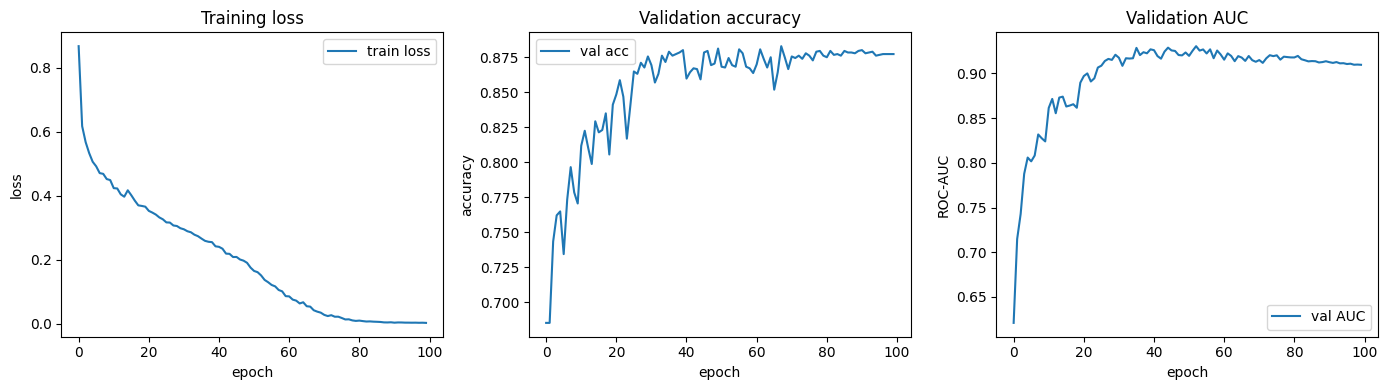

In [30]:
plt.figure(figsize=(14,4))
plt.subplot(1,3,1)
plt.plot(train_losses, label='train loss')
plt.xlabel('epoch'); plt.ylabel('loss'); plt.title('Training loss'); plt.legend()
plt.subplot(1,3,2)
plt.plot(val_accs, label='val acc')
plt.xlabel('epoch'); plt.ylabel('accuracy'); plt.title('Validation accuracy'); plt.legend()
plt.subplot(1,3,3)
plt.plot(val_aucs, label='val AUC')
plt.xlabel('epoch'); plt.ylabel('ROC-AUC'); plt.title('Validation AUC'); plt.legend()
plt.tight_layout(); plt.show()


## 8) Reload best checkpoint and evaluate on validation

In [31]:
if best_path.exists():
    ckpt = torch.load(best_path, map_location=DEVICE)
    model.load_state_dict(ckpt['model_state'])
    print(f'Loaded best checkpoint from epoch {ckpt.get("epoch")}, val_acc={ckpt.get("acc"):.4f}')

model.eval()
y_true, y_pred = [], []
with torch.no_grad():
    for batch in tqdm(val_loader, desc='Eval best [val]'):
        xb = batch['pixel_values'].to(DEVICE)
        yb = batch['label']
        with torch.cuda.amp.autocast(enabled=USE_AMP):
            logits = model(xb)
        pr = logits.argmax(1).cpu()
        y_true += yb.numpy().tolist()
        y_pred += pr.numpy().tolist()

from sklearn.metrics import classification_report
print(classification_report(y_true, y_pred))


Loaded best checkpoint from epoch 68, val_acc=0.8828


Eval best [val]:   0%|          | 0/14 [00:00<?, ?it/s]

/tmp/ipykernel_3879844/2812230969.py:12: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=USE_AMP):
Eval best [val]: 100%|██████████| 14/14 [00:07<00:00,  1.94it/s]

              precision    recall  f1-score   support

           0       0.89      0.95      0.92      1216
           1       0.86      0.75      0.80       558

    accuracy                           0.88      1774
   macro avg       0.88      0.85      0.86      1774
weighted avg       0.88      0.88      0.88      1774



In [32]:
## 9) Confusion matrix

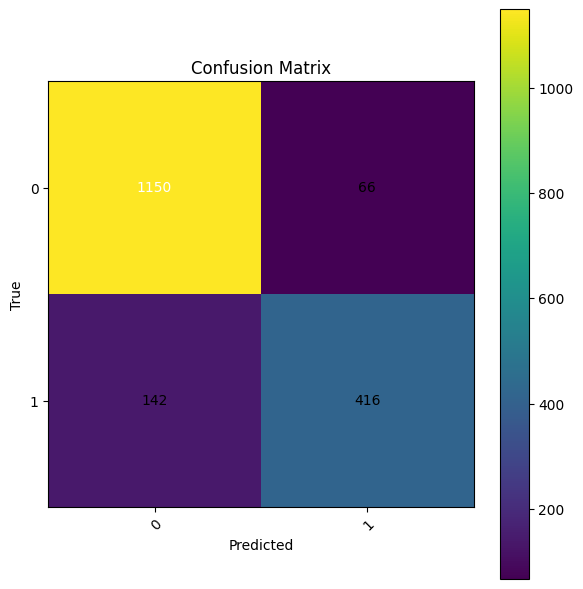

In [33]:
from sklearn.metrics import confusion_matrix
import numpy as np, matplotlib.pyplot as plt
cm = confusion_matrix(y_true, y_pred)
fig, ax = plt.subplots(figsize=(6,6))
im = ax.imshow(cm, interpolation='nearest')
ax.figure.colorbar(im, ax=ax)
ax.set(xticks=np.arange(cm.shape[1]), yticks=np.arange(cm.shape[0]),
       xlabel='Predicted', ylabel='True', title='Confusion Matrix')
plt.setp(ax.get_xticklabels(), rotation=45, ha='right', rotation_mode='anchor')
thresh = cm.max() / 2.
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        ax.text(j, i, format(cm[i, j], 'd'), ha='center', va='center',
                color='white' if cm[i, j] > thresh else 'black')
fig.tight_layout(); plt.show()
